In [51]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt

In [52]:
vocab_size = 256
x_ = list(map(ord,"hello"))
y_ = list(map(ord,"hola"))

In [53]:
x = torch.LongTensor(x_)
print(x)
y = torch.LongTensor(y_)
print(y)

tensor([104, 101, 108, 108, 111])
tensor([104, 111, 108,  97])


In [54]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.GRU(hidden_size, hidden_size) 
        self.project = nn.Linear(hidden_size, vocab_size) # 디코더가 번역문의 다음 토큰을 예상해내는 작은 신경망
    
    def forward(self, inputs, targets):
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1)
        encoder_output, encoder_state = self.encoder(embedding, initial_state)
        decoder_state = encoder_state
        decoder_input = torch.LongTensor([0]) # 문장 시작 토큰 추가
        
        outputs = []
        for i in range(targets.size()[0]):
            decoder_input = self.embedding(decoder_input).unsqueeze(1) 
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state) # 디코더는 시작토큰과 문맥 벡터를 동시에 입력받는다.
            
            projection = self.project(decoder_output) 
            outputs.append(projection) # 디코더가 예측한 결과가 outputs에 저장된다.
            decoder_input = torch.LongTensor([targets[i]]) # 티처 포싱을 사용해 디코더 학습 시 
                                                           #실제 번역문의 토큰을 디코더의 전 출력값 대신 입력으로 사용한다.
                                                           # why use teacher forcing? 
                                                           # 우리가 만든 모델은 충분한 데이터로 학습이 이루어지지 않았기 때문에 잘못된 예측 토큰을 입력으로 사용할 확률이 높다.
                                                           # 이런 상황이 반복되면 학습이 매우 더뎌지기 때문에 teacher forcing을 사용해 학습 속도를 개선한다.
        outputs = torch.stack(outputs).squeeze()
        return outputs
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()

In [55]:
seq2seq = Seq2Seq(vocab_size, 16)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-3)

In [56]:
log = []
for i in range(1000):
    prediction = seq2seq(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data
    log.append(loss_val)
    if i%100 == 0:
        print(f"반복 : {i}, 오차 : {loss_val.item()}")
        _, top1 = prediction.data.topk(1,1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])

반복 : 0, 오차 : 5.784719467163086
['°', 'O', 'Î', '¡']
반복 : 100, 오차 : 2.17873477935791
['h', 'o', 'l', 'a']
반복 : 200, 오차 : 0.6377769708633423
['h', 'o', 'l', 'a']
반복 : 300, 오차 : 0.35658738017082214
['h', 'o', 'l', 'a']
반복 : 400, 오차 : 0.2442733496427536
['h', 'o', 'l', 'a']
반복 : 500, 오차 : 0.1831926554441452
['h', 'o', 'l', 'a']
반복 : 600, 오차 : 0.14374445378780365
['h', 'o', 'l', 'a']
반복 : 700, 오차 : 0.11612489819526672
['h', 'o', 'l', 'a']
반복 : 800, 오차 : 0.09538891911506653
['h', 'o', 'l', 'a']
반복 : 900, 오차 : 0.07282198965549469
['h', 'o', 'l', 'a']


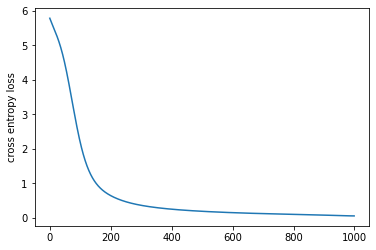

In [57]:
plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()